In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [85]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
# mixed_volumetric_dataset_term = pd.read_csv(
#     preprocessed_dataset_path +
#     'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [86]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
df = european_volumetric_dataset_term.copy()
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
df = data_exploration.MassUnivariate.remove_outliers(df,
                                                    col=dependentVar,
                                                     threshold=3,
                                                    remove_schemes='percentage',
                                                    percentage_of_outlier=0.1)
df = df.rename(columns = {'AAL 93':'AAL 109'})
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]

In [87]:
# imputed_PRS = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix='PRS_',column_suffix='_ASD_AllLDimputed')

PRS_ASD_EuroLD=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_Euro_LD')
PRS_SCZ_EuroLD = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/scz/SCZ_eur_ld_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_SCZ_Euro_LD')
# PRS_ASD_EuroLD_imputed=genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/ASD_eurold_HPC_merged_0_8_maf_geno_hwe_EUROPEANS.gwas.all.score',column_prefix = 'PRS_',column_suffix='_ASD_EuroLDimputed')

df = df.rename(columns={i:i+'_ASD_All_LD' for i in df.columns if 'PRS' in i})

# df = df.merge(imputed_PRS,left_on='ID',right_on=imputed_PRS.index)
df = df.merge(PRS_ASD_EuroLD,left_on='ID',right_on=PRS_ASD_EuroLD.index)
# df = df.merge(PRS_SCZ_EuroLD,left_on='ID',right_on=PRS_SCZ_EuroLD.index)


# df = df.merge(PRS_ASD_EuroLD_imputed,left_on='ID',right_on=PRS_ASD_EuroLD_imputed.index)

In [88]:
df.shape

(205, 4531)

In [89]:
# # plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['patch.edgecolor'] = 'none'
# plt.rcParams["axes.grid.axis"] ="y"
# sns.set_style('whitegrid')
# g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
# g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
# g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
# g.set_ylabels('Number of subjects',fontsize=15)
# g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
# g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
# g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
# g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


# g.axes[0][0].set_title('cohort = European',size=15)
# g.axes[0][1].set_title('cohort = Asian',size=15)
# plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
# sns.despine(bottom=True,left=True)
# # g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [10]:
combined = df[[
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]].copy()
combined = df[[i for i in df.columns if ('Euro' in i)]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
_ = data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 9.127512373677058
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 7.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.007142857142857142


In [11]:
0.05/28/6

0.00029761904761904765

In [12]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('AAL \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  6.02it/s]


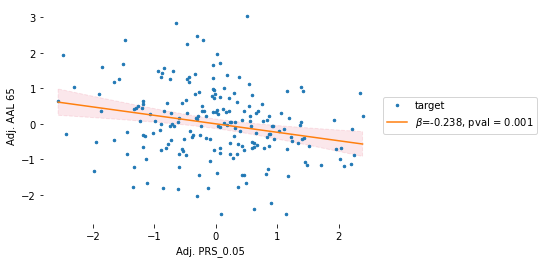

In [33]:
ylabel='AAL 65'
xlabel = 'PRS_0.05'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)'],
    dependentVar_cols=[ylabel])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [90]:
# dependentVar_cols=[i for i in combined.columns if bool(re.search('Imperial \d',i))]
# dependentVar_cols = data_preprocessing.Volumes.extract_GM_Imperial(dependentVar_cols)
# df = european_volumetric_dataset_term
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components = .8)

In [14]:
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=X_pca)


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 49.69it/s]


In [14]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if ('Euro' in i)]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
122,Dependent_Var_3,0.030171,0.794217,0.038325,0.720670,-0.789434,9.352137e-07,0.512313,1.276253e-04,0.041837,0.614004,-0.091565,0.266762,-0.078021,0.332557,0.299650,0.000335,-0.063764,0.719653,PRS_0.01_ASD_Euro_LD
129,Dependent_Var_3,0.044851,0.700891,0.025109,0.816475,-0.764431,2.433855e-06,0.497402,2.336852e-04,0.045038,0.592188,-0.076822,0.354921,-0.057952,0.474955,0.243355,0.003528,-0.094788,0.596543,PRS_0.05_ASD_Euro_LD
80,Dependent_Var_3,0.065723,0.573192,-0.027666,0.799051,-0.700962,1.749200e-05,0.475488,4.660383e-04,0.037132,0.658585,-0.058014,0.483710,-0.076579,0.348568,0.230970,0.005393,-0.138898,0.436339,PRS_1e-08_ASD_Euro_LD
136,Dependent_Var_3,0.055925,0.632743,0.013579,0.900333,-0.757473,3.237157e-06,0.499993,2.294804e-04,0.044220,0.600624,-0.085665,0.307057,-0.055495,0.495531,0.220299,0.008392,-0.118192,0.509506,PRS_0.1_ASD_Euro_LD
108,Dependent_Var_3,0.014480,0.903071,0.007346,0.945962,-0.747344,4.367925e-06,0.499890,2.307608e-04,0.026396,0.753448,-0.059750,0.471782,-0.075212,0.358256,0.225354,0.008707,-0.030602,0.868317,PRS_0.0001_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Dependent_Var_4,-0.000698,0.995635,0.028280,0.810028,-0.208325,2.247332e-01,0.159728,2.685787e-01,0.007285,0.936157,0.010564,0.906860,0.099556,0.259191,0.006143,0.945803,0.001475,0.994015,PRS_1e-05_ASD_Euro_LD
123,Dependent_Var_4,0.001229,0.992283,0.026992,0.818657,-0.207488,2.269285e-01,0.159831,2.682889e-01,0.006674,0.941593,0.011890,0.895395,0.100163,0.257665,-0.005298,0.953200,-0.002597,0.989380,PRS_0.01_ASD_Euro_LD
111,Dependent_Var_6,-0.002255,0.982811,0.145496,0.128334,0.015382,9.121187e-01,-0.053788,6.469505e-01,0.070255,0.342704,-0.051609,0.480082,-0.015527,0.829226,0.003775,0.959833,0.004765,0.976600,PRS_0.0001_ASD_Euro_LD
133,Dependent_Var_0,0.197700,0.062085,-0.081619,0.404233,0.330638,2.135149e-02,7.801255,1.595447e-134,-0.037729,0.620337,-0.170332,0.025033,0.033154,0.651486,-0.003567,0.961910,-0.417819,0.010298,PRS_0.1_ASD_Euro_LD


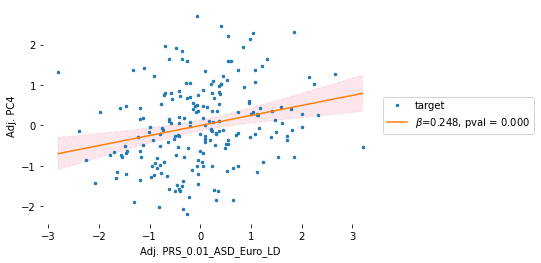

In [70]:
# PC4 was associated with the PRS 0.01 and 0.05
xlabel = 'PRS_0.01_ASD_Euro_LD'
ylabel = 'PC4'
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=[xlabel])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel=f'Adj. {xlabel}', ylabel=f'Adj. {ylabel}',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [56]:
data_exploration.MassUnivariate.get_model_summary(df,
                                                 cat_independentVar_cols=['Gender'],
                                                  cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)','PRS_0.01_ASD_Euro_LD']+ancestry,
                                                  dependentVar_cols=X_pca[:,3].reshape(-1,1))

,beta_coefs,pvalues,Rsquared
const,0.023571,7.942173e-01,0.000262
PMA_vol,-0.616736,9.352137e-07,0.098641
GA_vol,0.029941,7.206704e-01,0.000493
17 ICV (all except bone),0.400239,1.276253e-04,0.058729
PRS_0.01_ASD_Euro_LD,0.234098,3.346392e-04,0.051242
euro_Anc_PC1,0.032685,6.140040e-01,0.000981
euro_Anc_PC2,-0.071534,2.667620e-01,0.004767
euro_Anc_PC3,-0.060953,3.325570e-01,0.003627
Gender_2.0,-0.049815,7.196534e-01,0.000497


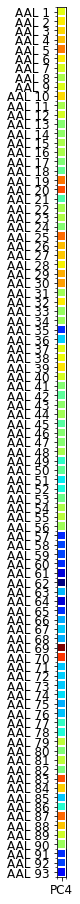

In [43]:
#see the loading matrix of PC4
fig,ax = plt.subplots(1,1,figsize=(20,16))
visualisation.visualise_heatmap(loading_matrix.loc[:,3:3],ax,xlabel=['PC4'],ylabel=loading_matrix.index.tolist())

In [57]:
plot_labels = [int(i.replace('AAL ','')) for i in loading_matrix.index]
plot_value_values = loading_matrix[3].values
plot_values = dict(zip(plot_labels,plot_value_values)) 

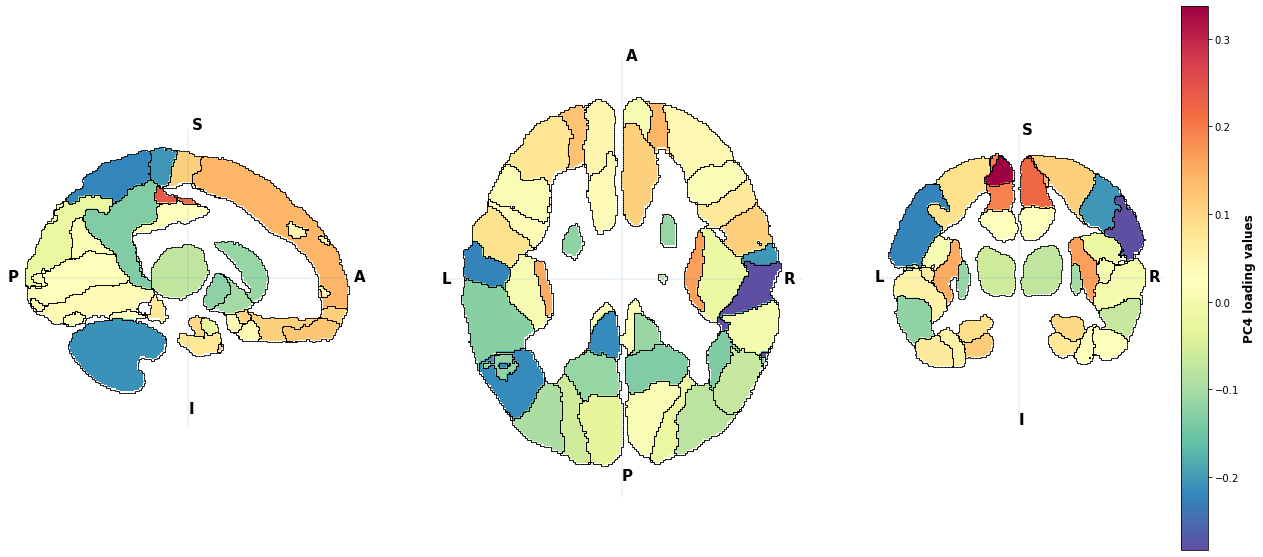

In [59]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],atlas_slice=120,plot_values=plot_values,colorbar=True,atlas_file = '../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',cb_orientation='vertical',cmap_reversed=True,cb_title = 'PC4 loading values')

In [36]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

Stability test

In [42]:
prs_cols = [i for i in df.columns if 'Euro' in i]

In [33]:
set1,set2 = data_exploration.Stability_tests.train_test_split_modified(df,'PRS_0.01_ASD_Euro_LD',random_state=2)

In [37]:
df = set1
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components = .8)

In [38]:
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=X_pca)

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 61.50it/s]


In [39]:
threshold = 'PRS_0.01_ASD_Euro_LD'
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']==threshold].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
85,Dependent_Var_0,-0.014927,0.937810,-0.231211,0.286975,0.521755,0.135927,7.742226,3.825193e-29,0.190776,0.217845,-0.164160,0.312304,0.035861,0.816184,0.194289,0.184936,0.034604,0.908242,PRS_0.01_ASD_Euro_LD
87,Dependent_Var_2,-0.023240,0.935836,-0.234947,0.471694,-0.311816,0.550319,0.309950,4.527386e-01,0.074849,0.746579,0.054396,0.823393,0.106177,0.648601,0.235115,0.285890,0.053876,0.905338,PRS_0.01_ASD_Euro_LD
86,Dependent_Var_1,0.050260,0.876273,-0.062521,0.863595,0.317232,0.586664,-0.359610,4.360105e-01,0.440636,0.094141,0.218131,0.425081,-0.539763,0.043002,0.258674,0.293564,-0.116513,0.818118,PRS_0.01_ASD_Euro_LD
89,Dependent_Var_4,-0.090786,0.721913,0.121742,0.672126,0.551951,0.234139,-0.469821,2.003185e-01,-0.165753,0.419205,0.022690,0.916012,0.084109,0.682586,-0.091567,0.635992,0.210459,0.599378,PRS_0.01_ASD_Euro_LD
88,Dependent_Var_3,0.084310,0.759203,-0.158621,0.609305,-0.383676,0.440897,0.452957,2.513421e-01,0.018231,0.934085,0.180327,0.438690,-0.187857,0.398597,-0.008581,0.967149,-0.195445,0.650891,PRS_0.01_ASD_Euro_LD


In [ ]:
european_volumetric_term_mass_univariate

In [73]:
loading_matrix

,0,1,2,3,4
AAL 1,0.870065,-0.146434,0.047798,0.263445,0.019750
AAL 2,0.908168,-0.050690,0.041308,0.152559,-0.104184
AAL 3,0.924829,-0.125678,0.129383,0.131217,0.002748
AAL 4,0.880850,-0.182080,0.118191,0.200317,-0.015188
AAL 5,0.884066,-0.081483,0.290802,-0.096051,-0.064586
...,...,...,...,...,...
AAL 89,0.853524,0.005798,-0.079711,-0.075273,-0.184562
AAL 90,0.911745,-0.074136,-0.085124,-0.074130,-0.198249
AAL 91,0.832435,0.143657,-0.256991,-0.136177,0.141777
AAL 92,0.857160,0.079466,-0.199803,-0.133242,0.205393


In [50]:
set2.shape

(26, 4531)

In [52]:
X_pca_set2.shape

(25, 3)

In [67]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [125]:
new_loading_matrix

,level_0,level_1,0
0,0,AAL 1,0.883781
1,0,AAL 2,0.888984
2,0,AAL 3,0.908797
3,0,AAL 4,0.882396
4,0,AAL 5,0.893803
...,...,...,...
646,6,AAL 89,0.003525
647,6,AAL 90,0.052662
648,6,AAL 91,0.034603
649,6,AAL 92,0.042444


In [172]:
temp_matrix = loading_matrix2
new_loading_matrix = pd.DataFrame(temp_matrix.unstack()).reset_index()
new_loading_matrix['X'] = [i for n in range(len(temp_matrix.columns)) for i in ROIs_coord.loc[0:92,'X']]
new_loading_matrix['Y'] = [i for n in range(len(temp_matrix.columns)) for i in ROIs_coord.loc[0:92,'Y']]
new_loading_matrix['Z'] = [i for n in range(len(temp_matrix.columns)) for i in ROIs_coord.loc[0:92,'Z']]
new_loading_matrix['split_number'] = [f'PC_{i+1}' for i in new_loading_matrix['level_0'].values] 
new_loading_matrix.rename(columns={0:'loading values'},inplace=True)

<AxesSubplot:xlabel='Sup-Inf axis', ylabel='PC loadings'>

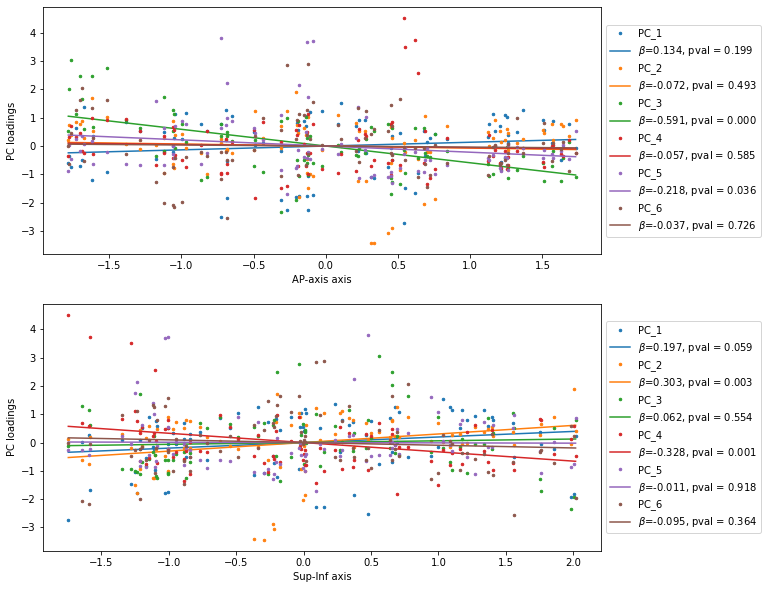

In [173]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
visualisation.plot_Linear_Reg('Y','loading values',data=new_loading_matrix,hue='split_number',scaling='both',ax=ax[0],markersize=5,ylabel='PC loadings',xlabel='AP-axis axis',hide_CI=True)
visualisation.plot_Linear_Reg('Z','loading values',data=new_loading_matrix,hue='split_number',scaling='both',ax=ax[1],markersize=5,ylabel='PC loadings',xlabel='Sup-Inf axis',hide_CI=True)

In [174]:
set2_mass_univariate.sort_values(by=f'{prs}_pval')

,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,PRS_0.01_ASD_Euro_LD_coef,PRS_0.01_ASD_Euro_LD_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
Dependent_Var_2,-0.010528,0.955732,-0.342321,0.058621,1.019827,0.000650,-0.668687,8.656402e-03,-0.267899,0.054182,-0.097129,0.498033,0.134089,0.331655,-0.047996,0.725375,0.022591,0.938675
Dependent_Var_3,-0.144070,0.442830,-0.475333,0.008465,0.448001,0.120193,-0.183950,4.572913e-01,0.228272,0.096076,-0.013673,0.923019,-0.059460,0.662509,0.103082,0.445784,0.309149,0.288184
Dependent_Var_4,0.092393,0.594389,0.384852,0.020646,-0.552182,0.039356,0.283518,2.167152e-01,-0.164947,0.192322,0.201736,0.125600,0.013186,0.916628,0.189599,0.131245,-0.198260,0.460811
Dependent_Var_5,0.349975,0.034243,0.004211,0.978245,-0.288729,0.249035,0.069656,7.463876e-01,0.145106,0.223138,0.118103,0.339294,-0.023814,0.840941,-0.116448,0.323431,-0.750989,0.003692
Dependent_Var_1,-0.261249,0.248860,-0.014944,0.944180,-0.032124,0.925813,0.163186,5.837873e-01,-0.188214,0.252738,0.050126,0.768708,0.035872,0.826882,0.122624,0.451399,0.560597,0.111146
Dependent_Var_0,0.434118,0.004952,-0.025839,0.856596,0.548890,0.019267,7.550708,8.053480e-59,0.003834,0.972157,0.048796,0.669229,-0.366616,0.001180,0.076793,0.481347,-0.931544,0.000131


In [62]:
set2_mass_univariate.sort_values(by=f'{prs}_pval')

,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,PRS_1e-08_ASD_Euro_LD_coef,PRS_1e-08_ASD_Euro_LD_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
Dependent_Var_4,-0.052135,0.869386,1.152976,0.016303,-2.757618,0.000686,1.371352,4.812485e-03,-0.488631,0.091471,0.566851,0.089404,0.694892,0.041206,-0.042321,0.878995,0.135552,0.793539
Dependent_Var_2,-0.383896,0.414999,0.182505,0.777734,-0.618228,0.536621,0.351344,5.799451e-01,0.691129,0.103619,0.095574,0.838895,-0.021578,0.963359,-0.049341,0.903957,0.998130,0.200870
Dependent_Var_0,0.330249,0.102314,-0.090369,0.737149,0.301342,0.470234,-8.019937,2.176261e-16,-0.252746,0.149150,-0.089602,0.647838,-0.519846,0.015227,0.270293,0.125387,-0.858647,0.013662
Dependent_Var_3,0.592273,0.180357,-0.691501,0.255137,0.540120,0.558250,-0.015862,9.782961e-01,0.187015,0.620481,0.032753,0.939777,-0.207878,0.632643,-0.080066,0.832021,-1.539909,0.039910
Dependent_Var_1,-0.484934,0.315444,-0.315048,0.633727,-0.058394,0.954124,-0.256564,6.913781e-01,-0.072135,0.862437,0.206247,0.667886,0.671766,0.172997,-0.748606,0.086230,1.260828,0.117844


In [167]:
prs_cols

['PRS_1e-08_ASD_Euro_LD',
 'PRS_1e-07_ASD_Euro_LD',
 'PRS_1e-06_ASD_Euro_LD',
 'PRS_1e-05_ASD_Euro_LD',
 'PRS_0.0001_ASD_Euro_LD',
 'PRS_0.001_ASD_Euro_LD',
 'PRS_0.01_ASD_Euro_LD',
 'PRS_0.05_ASD_Euro_LD',
 'PRS_0.1_ASD_Euro_LD',
 'PRS_0.5_ASD_Euro_LD',
 'PRS_1_ASD_Euro_LD']

In [ ]:
model_summary = defaultdict(dict)
for split_number in range(1,11):
    set1,set2 = data_exploration.Stability_tests.train_test_split_modified(df,
                                                                           'GA_vol',
                                                                           'PMA_vol',
                                                                           random_state=split_number)
    dependentVar_cols = [
        i for i in df.columns
        if bool(re.search('AAL \d', i))
    ]
    _, X_pca_set1, loading_matrix1 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set1,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    _, X_pca_set2, loading_matrix2 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
        df=set2,
        dependentVar_cols=dependentVar_cols,
        scaling=True,n_components = .8)
    model_summary[f'split_{split_number}']=defaultdict(dict)
    model_summary[f'split_{split_number}']['set1']['loading_matrix']=loading_matrix1
    model_summary[f'split_{split_number}']['set2']['loading_matrix']=loading_matrix2

    set1_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set1,
        thresholds=['PRS_0.01_ASD_Euro_LD'],
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set1)
    set2_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
        df=set2,
        thresholds = ['PRS_0.01_ASD_Euro_LD'],
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
        dependentVar_cols=X_pca_set2)
    
    model_summary[f'split_{split_number}']['set1']['mass_univariate']=set1_mass_univariate
    model_summary[f'split_{split_number}']['set2']['mass_univariate']=set2_mass_univariate


In [168]:
model_summary = defaultdict(dict)
for prs in ['PRS_0.01_ASD_Euro_LD']:
    for split_number in range(5):
        set1,set2 = data_exploration.Stability_tests.train_test_split_modified(df,prs,'GA_vol','PMA_vol',random_state=2)
        dependentVar_cols = [
            i for i in df.columns
            if bool(re.search('AAL \d', i))
        ]
        _, X_pca_set1, loading_matrix1 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
            df=set1,
            dependentVar_cols=dependentVar_cols,
            scaling=True,n_components = .8)
        _, X_pca_set2, loading_matrix2 = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
            df=set2,
            dependentVar_cols=dependentVar_cols,
            scaling=True,n_components = .8)
        model_summary[prs][split_number]=defaultdict(dict)
        model_summary[prs][split_number]['set1']=defaultdict(list)
        model_summary[prs][split_number]['set2']=defaultdict(list)
        
        model1,set1_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            df=set1,
            cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)',prs]+ancestry,
            dependentVar_cols=X_pca_set1)
        model2,set2_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            df=set2,
            cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)',prs]+ancestry,
            dependentVar_cols=X_pca_set2)

changing bins for 1 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 1 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 1 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 1 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 1 argument
changing bins for 2 argument
changing bins for 2 argument
changing bins for 2 argument


## Imperial Atlas

In [22]:
df.shape

(205, 4520)

In [127]:
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping='gmwm2gether',remove_duplicated=False)
deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
df = df.drop(columns=['Imperial 83','Imperial 84','Imperial 85'])




In [138]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 22/22 [00:03<00:00,  5.90it/s]


In [139]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]
european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval').groupby('Connection').head(1).head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
1466,Imperial 39,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1509,Imperial 82,0.112328,0.001245,-0.023497,0.460373,0.148113,0.001599,0.818412,3.936469e-52,-0.021625,0.380113,-0.019727,0.419905,0.073000,0.002512,-0.077292,0.001754,-0.237394,0.000011,PRS_0.01_ASD_Euro_LD
1465,Imperial 38,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1508,Imperial 81,0.082651,0.019732,-0.000971,0.976260,0.124408,0.009432,0.831139,1.462638e-51,-0.006597,0.793813,-0.011510,0.646096,0.078786,0.001490,-0.068411,0.006741,-0.174675,0.001427,PRS_0.01_ASD_Euro_LD
1840,Imperial 77,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1797,Imperial 34,0.052902,0.338357,-0.052045,0.308880,0.069079,0.355244,0.799852,1.818948e-27,-0.009592,0.810847,0.021791,0.579329,0.079789,0.038647,-0.091651,0.020309,-0.111803,0.186868,PRS_1_ASD_Euro_LD
1338,Imperial 79,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1295,Imperial 36,0.070413,0.017363,-0.013077,0.625440,-0.040457,0.302029,0.969866,6.948019e-74,-0.002795,0.892951,-0.014784,0.471285,-0.007171,0.722793,0.048796,0.021275,-0.148812,0.001285,PRS_0.0001_ASD_Euro_LD
1296,Imperial 37,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD
1339,Imperial 80,0.063475,0.031330,-0.030454,0.255035,-0.017793,0.648697,0.963212,1.384004e-73,-0.017134,0.408498,-0.025098,0.220738,-0.011625,0.564379,0.048496,0.021738,-0.134147,0.003540,PRS_0.0001_ASD_Euro_LD


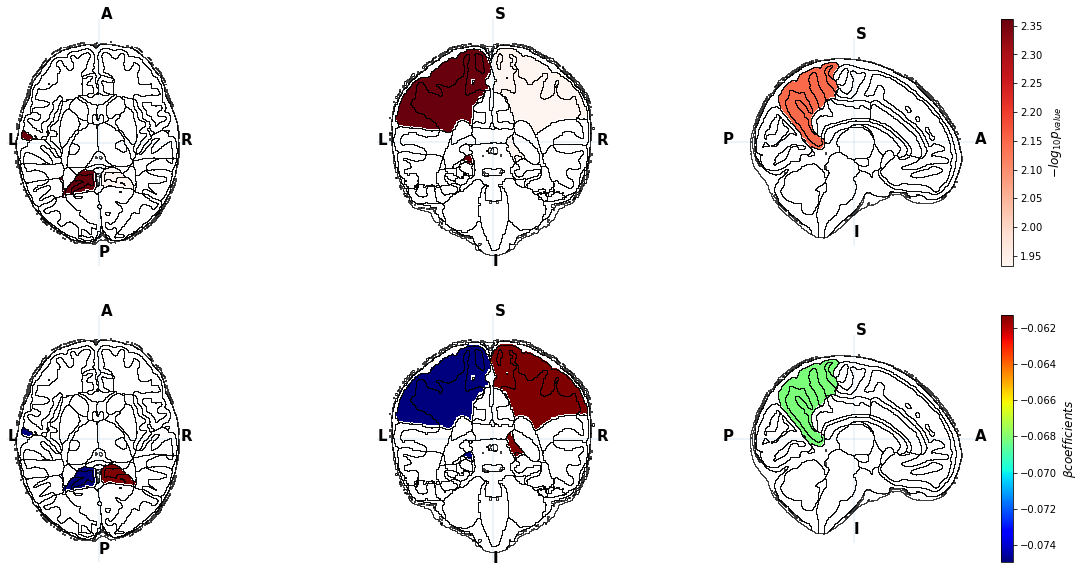

In [37]:
significant_regions = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.01'].copy()

plot_values_pvals = {indx+1:-np.log10(value) for indx,value in enumerate(significant_regions['PRS_pval'])}

plot_values_coefs = {indx+1:value for indx,value in enumerate(significant_regions['PRS_coef'])}

fig, axes = plt.subplots(2,3,figsize=(20,10))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                              axes=axes[0,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$-log_{10}p_{value}$',
                                                              cmap='Reds',
                                                              cmap_reversed=False)

_, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['all'],
                                                              plot_values=plot_values_pvals,
                                                              plot_values_threshold=-np.log10(0.05),
                                                            mask = plot_values_coefs,
                                                              axes=axes[1,:],
                                                            fig = fig,
                                                              atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',
                                                              colorbar=True,
                                                              cb_orientation='vertical',
                                                              cb_title=r'$\beta coefficients$',
                                                              cmap='jet',
                                                              cmap_reversed=False)

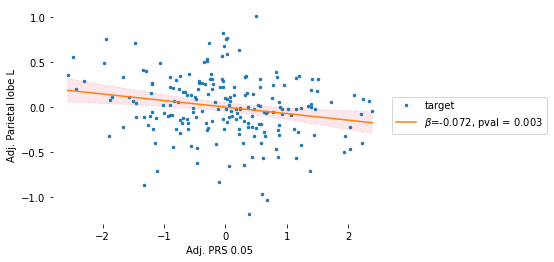

In [26]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 39'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. Parietal lobe L',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [13]:
len(combined.columns)

84

In [82]:
# euro_WM = data_preprocessing.Volumes.extract_WM_Imperial(df)
# euro_GM = data_preprocessing.Volumes.extract_GM_Imperial(df)
# euro_DGM = data_preprocessing.Volumes.extract_deepGM_Imperial(df)
# deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
combined = df[[
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]].copy()
# combined.drop(columns=deepGM,inplace=True)
# combined = pd.concat([euro_WM,euro_GM],axis=1)
# combined = df[[i for i in df.columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 30.537095519088055
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 20.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.002499999999999996


In [155]:
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components=.8)

In [141]:
0.05/7/7

0.0010204081632653062

In [142]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]


european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=X_pca)

100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 42.98it/s]


In [145]:
thresholds = [i for i in european_volumetric_term_mass_univariate['threshold'] if 'Euro' in i]


european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'].isin(thresholds)].sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
87,Dependent_Var_3,0.104430,0.251763,-0.020866,0.804448,-0.463442,0.000239,0.237552,2.354691e-02,0.204492,0.002088,0.115645,0.074491,-0.039549,0.534357,0.131863,0.042549,-0.220702,0.113944,PRS_1e-07_ASD_Euro_LD
80,Dependent_Var_3,0.108964,0.231672,-0.037402,0.658978,-0.459112,0.000283,0.236233,2.451209e-02,0.200315,0.002511,0.119052,0.066340,-0.039214,0.537990,0.127802,0.047279,-0.230285,0.098819,PRS_1e-08_ASD_Euro_LD
149,Dependent_Var_2,-0.081308,0.417484,0.025639,0.782196,0.173632,0.201024,0.006898,9.518182e-01,-0.041379,0.569712,0.043653,0.540774,0.059069,0.396940,-0.133021,0.062920,0.171836,0.263524,PRS_1_ASD_Euro_LD
142,Dependent_Var_2,-0.082056,0.413990,0.027009,0.771257,0.169900,0.211437,0.008764,9.389353e-01,-0.039277,0.589922,0.040846,0.567201,0.060443,0.386892,-0.120960,0.090753,0.173417,0.260008,PRS_0.5_ASD_Euro_LD
92,Dependent_Var_1,0.099867,0.316180,-0.115315,0.213224,0.407979,0.002800,-0.375062,1.185582e-03,0.009832,0.890691,-0.044773,0.526480,-0.013230,0.849348,-0.114803,0.101839,-0.211058,0.166297,PRS_1e-06_ASD_Euro_LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Dependent_Var_5,-0.204175,0.043317,0.201145,0.031601,-0.259688,0.057245,0.146808,2.008253e-01,0.068408,0.349191,0.029579,0.679433,-0.012761,0.855130,-0.005125,0.942812,0.431503,0.005509,PRS_1_ASD_Euro_LD
97,Dependent_Var_6,0.067821,0.493708,0.017185,0.851857,-0.329783,0.014813,0.202608,7.563492e-02,-0.037027,0.603142,-0.133812,0.058184,-0.050672,0.465053,0.004268,0.951104,-0.143332,0.344273,PRS_1e-06_ASD_Euro_LD
119,Dependent_Var_0,0.080262,0.003056,-0.052990,0.033800,0.120311,0.001032,0.876817,1.646798e-72,-0.001015,0.957854,-0.010528,0.581091,-0.002878,0.877267,-0.001007,0.957800,-0.169625,0.000054,PRS_0.01_ASD_Euro_LD
150,Dependent_Var_3,0.112500,0.222382,-0.020605,0.808835,-0.493122,0.000102,0.258901,1.426715e-02,0.191857,0.004489,0.120594,0.066829,-0.026836,0.674970,0.003045,0.962869,-0.237757,0.092744,PRS_1_ASD_Euro_LD


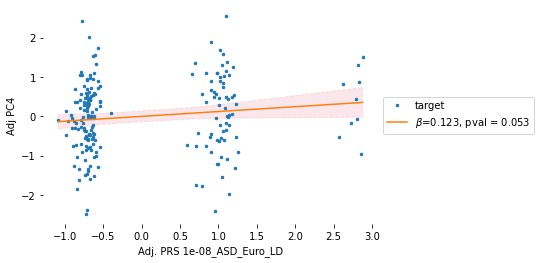

In [150]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-08_ASD_Euro_LD'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1e-08_ASD_Euro_LD',ylabel='Adj PC4',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [156]:
loading_values = loading_matrix[3].values
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.index.tolist()]

In [152]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_1e-07_ASD_Euro_LD'].copy()

In [153]:
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

ValueError: invalid literal for int() with base 10: 'Dependent_Var_0'

In [159]:
plot_values=dict(zip(loading_labels,loading_values))

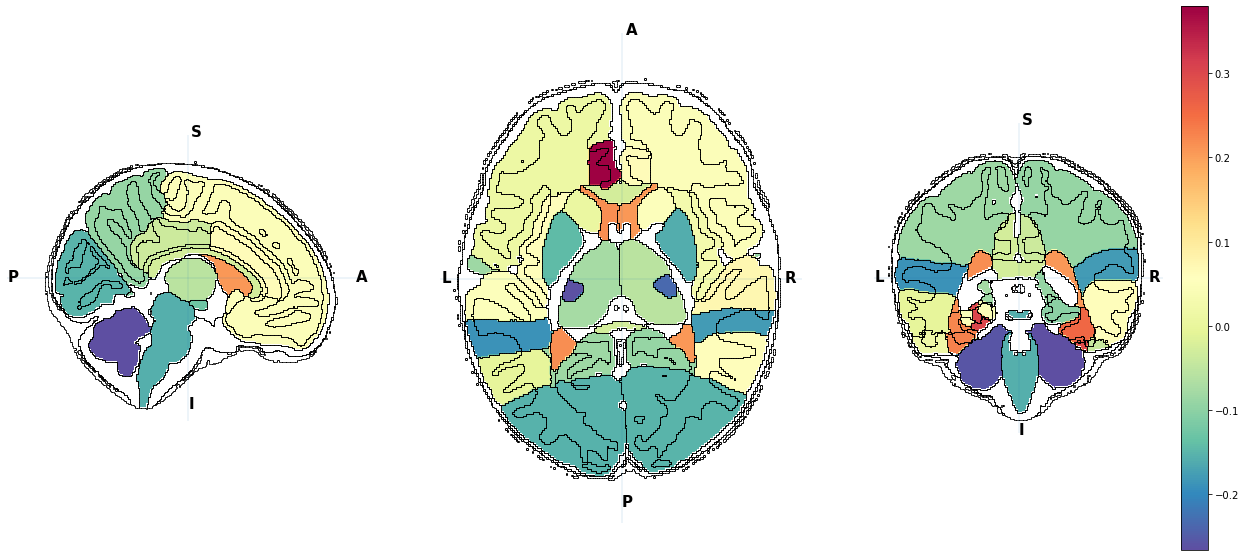

In [161]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[83,84,85],plot_values=dict(zip(loading_labels,loading_values)),colorbar=True,atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',orientation='vertical',cmap_reversed=True)

In [102]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
626,Imperial 39,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
669,Imperial 82,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
625,Imperial 38,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
668,Imperial 81,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
594,Imperial 7,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
640,Imperial 53,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
589,Imperial 2,0.055418,0.420161,0.020557,0.747719,-0.019350,0.835210,0.744486,6.750234e-18,-0.014436,0.770296,0.001933,0.968490,0.049428,0.301845,-0.075442,0.119272,-0.117120,0.265883,PRS_0.05
607,Imperial 20,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
650,Imperial 63,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
616,Imperial 29,0.004149,0.935496,0.098326,0.040297,-0.128259,0.065803,0.929503,3.513508e-37,-0.013221,0.720120,0.028633,0.433366,-0.003974,0.911304,-0.053962,0.135315,-0.008768,0.910997,PRS_0.05


In [162]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates(atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [163]:
ROIs_coord = ROIs_coord[~ROIs_coord['Label'].isin([83,84,85])]

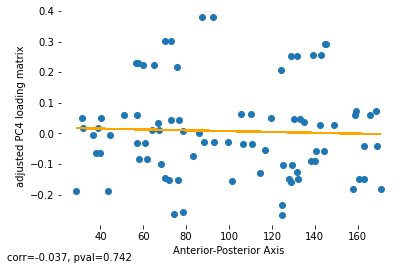

In [167]:
visualisation.plot_correlation(ROIs_coord['X'],loading_values,xlabel='Anterior-Posterior Axis',ylabel=r'adjusted PC4 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [ ]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=dependentVar_cols,
                                                    thresholds=thresholds)

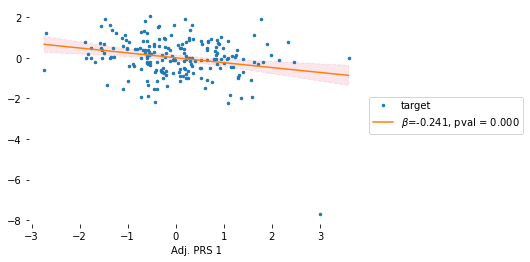

In [149]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 38'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-06'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

We get the following summary table of R2, beta and p-value of association between PRS and brain volumes

In [14]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=['Imperial 79', 'Imperial 58', 'Imperial 12', 'WM_sum_Imperial'],
                                                    thresholds=thresholds)

In [15]:
summary_table

GA_vol       PMA_vol  \
Imperial 79     PRS_1e-08 R2     2.151483e-07  5.581806e-02   
                          Beta   1.163305e-03 -4.655917e-01   
                          P_val  9.737014e-01  2.193130e-16   
                PRS_1e-07 R2     2.151483e-07  5.581806e-02   
                          Beta  -4.715114e-05 -4.633134e-01   
...                                       ...           ...   
WM_sum_Imperial PRS_0.5   Beta  -2.090412e-02 -3.504964e-01   
                          P_val  4.976230e-01  7.648056e-13   
                PRS_1     R2     2.069066e-04  3.168293e-02   
                          Beta  -2.117077e-02 -3.491695e-01   
                          P_val  4.918391e-01  9.191190e-13   

                                 Intracranial_Imperial  mixed_Anc_PC1  \
Imperial 79     PRS_1e-08 R2              4.345161e-01       0.000042   
                          Beta            1.111430e+00       0.001041   
                          P_val           1.504568e-69       0.972560   
                PRS_1e-07 R2              4.345161e-01       0.000042   
                          Beta            1.109018e+00      -0.000937   
...                                                ...            ...   
WM_sum_Imperial PRS_0.5   Beta            1.092073e+00      -0.000195   
                          P_val           1.989428e-78       0.995132   
                PRS_1     R2              4.196961e-01       0.000481   
                          Beta            1.090843e+00      -0.002398   
                          P_val           2.625290e-78       0.940021   

                                 mixed_Anc_PC2  mixed_Anc_PC3  mixed_Anc_PC4  \
Imperial 79     PRS_1e-08 R2          0.000154       0.001059       0.000422   
                          Beta       -0.029123      -0.063549       0.024028   
                          P_val       0.570351       0.226530       0.406298   
                PRS_1e-07 R2          0.000154       0.001059       0.000422   
                          Beta       -0.028789      -0.063398       0.024302   
...                                        ...            ...            ...   
WM_sum_Imperial PRS_0.5   Beta        0.024430       0.001851       0.022922   
                          P_val       0.585327       0.968076       0.363892   
                PRS_1     R2          0.000128       0.000014       0.000426   
                          Beta        0.024602       0.002582       0.022865   
                          P_val       0.582377       0.955443       0.364681   

                                 mixed_Anc_PC5  Gender  PRS_1e-08  ...  \
Imperial 79     PRS_1e-08 R2          0.000126     0.0   0.000000  ...   
                          Beta       -0.009900     NaN  -0.074038  ...   
                          P_val       0.721709     NaN   0.005687  ...   
                PRS_1e-07 R2          0.000126     0.0        NaN  ...   
                          Beta       -0.010466     NaN        NaN  ...   
...                                        ...     ...        ...  ...   
WM_sum_Imperial PRS_0.5   Beta       -0.020695     NaN        NaN  ...   
                          P_val       0.394847     NaN        NaN  ...   
                PRS_1     R2          0.000294     0.0        NaN  ...   
                          Beta       -0.020826     NaN        NaN  ...   
                          P_val       0.391380     NaN        NaN  ...   

                                 PRS_1e-07  PRS_1e-06  PRS_1e-05  PRS_0.0001  \
Imperial 79     PRS_1e-08 R2           NaN        NaN        NaN         NaN   
                          Beta         NaN        NaN        NaN         NaN   
                          P_val        NaN        NaN        NaN         NaN   
                PRS_1e-07 R2      0.000000        NaN        NaN         NaN   
                          Beta   -0.076941        NaN        NaN         NaN   
...                                    ...        ...        ...         ..

We get the following plots

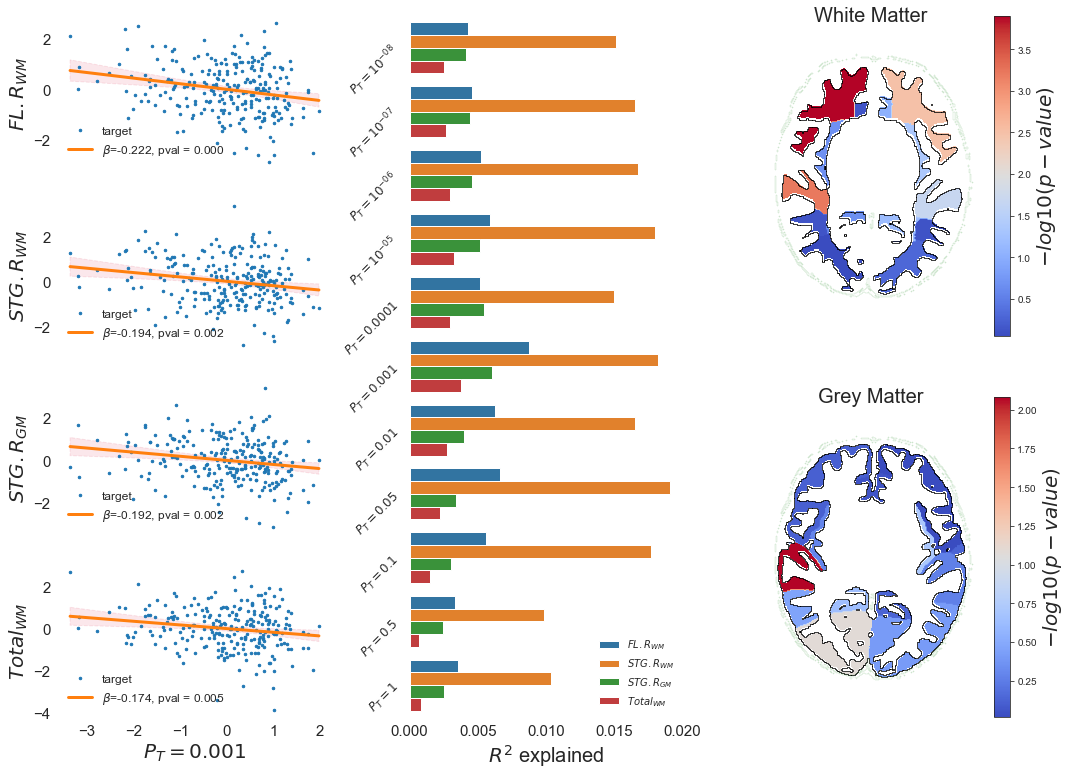

In [138]:
sns.set_style('white')
fig,axes = plt.subplots(4,3,sharex = True,figsize=(15,11))
# fig = plt.figure(figsize=(20,10))
# ax1 = plt.subplot(4,3,1)
# ax2 = plt.subplot(4,3,4)
# ax3 = plt.subplot(4,3,7)
# ax4 = plt.subplot(4,3,10)
for ax in axes[:,1:].flatten():
    ax.remove()
bar_plot = plt.subplot(132)
WM_plot = plt.subplot(233)
GM_plot = plt.subplot(236)
# plt.tight_layout(w_pad =.5, h_pad=.2)
dependent_var = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']
ylbl = ['$FL.R_{WM}$', '$STG.R_{WM}$', '$STG.R_{GM}$','$Total_{WM}$']
threshold = 'PRS_0.001'
thresholds_label = '$P_T = 0.001$'
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1,4)]
# axes = axes.flatten()
df = mixed_volumetric_dataset_term
# draw the scatter plot
for ax,dependent_variable, ylabel in zip(axes[:,0],dependent_var,ylbl):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender'],
                                                              cont_independentVar_cols=[
                                                                  'GA_vol','PMA_vol','Intracranial_Imperial'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)
axes[-1,0].set_xlabel(f'{thresholds_label}',fontsize=20)

    
#draw the barplot of R-squared explained
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = data_exploration.MassUnivariate.calculate_R_squared_explained(df = df,col_to_drop=threshold,cat_independentVar_cols=['Gender'],cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry_list,dependentVar_cols=[dependent_variable])
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ylbl

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)
g.set_yticklabels(['$P_T = 10^{-08}$','$P_T = 10^{-07}$',
                     '$P_T = 10^{-06}$','$P_T = 10^{-05}$',
                     '$P_T = 0.0001$','$P_T = 0.001$',
                     '$P_T = 0.01$','$P_T = 0.05$',
                    '$P_T = 0.1$','$P_T = 0.5$','$P_T = 1$'],fontsize=12,rotation = 45)
g.tick_params(axis='x', labelsize=15)
bar_plot.legend(frameon=False)

#import the atlas
import nibabel as nib
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

df = mixed_volumetric_term_mass_univariate[mixed_volumetric_term_mass_univariate['threshold'] == 'PRS_0.001'].copy()

df = df[[bool(re.search(r'[1-9]',i)) for i in df['Connection']]].sort_values(by='PRS_pval').reset_index(drop=True)
df['Connection_ID'] = [int(i.split(' ')[1]) for i in df['Connection']]

# Create a new volume of the same size as the atlas
atlas_coeffs_WM = np.zeros_like(atlas)
atlas_coeffs_GM = np.zeros_like(atlas)


WM_df = extract_WM_Imperial(df).reset_index(drop=True)
GM_df = extract_GM_Imperial(df).reset_index(drop=True)
# fig,axes = plt.subplots(1,2,figsize=(20,10))
# Here you will replace each index (0...87) from the atlas with the coefficients you want to plot
for i in WM_df['Connection_ID'].tolist():
    atlas_coeffs_WM[atlas == i] = -np.log10(WM_df.loc[WM_df['Connection_ID'] == i,'PRS_pval'].values)

for i in GM_df['Connection_ID'].tolist():
    atlas_coeffs_GM[atlas == i] = -np.log10(GM_df.loc[GM_df['Connection_ID'] == i,'PRS_pval'].values)


# im1 = WM_plot.imshow(np.rot90(atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]),cmap='coolwarm')
# im2 = GM_plot.imshow(np.rot90(atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]),cmap='coolwarm')

import copy
from matplotlib.collections import LineCollection

cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
cmap.set_bad(alpha=0)

# atlas_coeffs_WM[atlas==84] = 0.1
WM_atlas = atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]
GM_atlas = atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]

WM_atlas[WM_atlas==0] = np.nan
GM_atlas[GM_atlas==0] = np.nan

im1 = WM_plot.imshow(np.rot90(WM_atlas),cmap=cmap)
im2 = GM_plot.imshow(np.rot90(GM_atlas),cmap=cmap)

WM_atlas[np.isnan(WM_atlas)] = 0
GM_atlas[np.isnan(GM_atlas)] = 0

brain_background = np.zeros(atlas.shape)
brain_background[atlas==84] = 1
brain_background = brain_background[:, :, brain_background.shape[2]//2]

cl_WM = LineCollection(visualisation.get_edges(np.rot90(WM_atlas)),lw=1,color='k')
WM_plot.add_collection(cl_WM)

cl_GM = LineCollection(visualisation.get_edges(np.rot90(GM_atlas)),lw=1,color='k')
GM_plot.add_collection(cl_GM)


cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
WM_plot.add_collection(cl_background)
cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
GM_plot.add_collection(cl_background)

for im,ax in zip([im1,im2],[WM_plot,GM_plot]):
    cbar = plt.colorbar(im,ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label('$-log10(p-value)$', fontsize=20)
WM_plot.set_title('White Matter',fontsize=20)
GM_plot.set_title('Grey Matter', fontsize=20)
# WM_plot.set_ylabel('White Matter',fontsize=20)
# GM_plot.set_ylabel('Grey Matter',fontsize=20)
plt.tight_layout()
fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_plots_mixed.svg')

# Other tests

## Stability test

1. We halve the sample into 2 equal data sets and see if similar results are given
2. We separate into high and low risks

### Halving the samples

In [45]:
common_list_WM = defaultdict(pd.DataFrame)
common_list_GM = defaultdict(pd.DataFrame)
ancestry = ['mixed_Anc_PC'+str(i) for i in range(1,6)]
df = mixed_volumetric_dataset_term
thresholds = [i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]
result_dict = defaultdict(dict)
for run in range(10):
    result_dict[f'split_{run+1}']=defaultdict(dict)
    for threshold in thresholds:
        result_dict[f'split_{run+1}'][threshold]=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_1']=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_2']=defaultdict(dict)
        
        train, test = data_exploration.train_test_split_modified(
            df,
            'GA_vol',
            'Gender',
            'cohort',
            random_state=run)
        _,train_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            train, cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])

        _,test_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            test, cat_independentVar_cols=['Gender'], cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])
        train_mass_univariate = train_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        test_mass_univariate = test_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        
        for col,colname in zip(train_mass_univariate.index.tolist(),['Total WM',
                                                                    'FL.R_WM',
                                                                    'STG.R_WM',
                                                                    'STG.R_GM']):
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['p_value'] = train_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['beta'] = train_mass_univariate.loc[col,'PRS_coef']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['p_value'] = test_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['beta'] = test_mass_univariate.loc[col,'PRS_coef']

In [46]:
halving_samples = pd.DataFrame.from_dict({(s, t, st, bv): result_dict[s][t][st][bv]
                        for s in result_dict.keys()
                        for t in result_dict[s].keys()
                        for st in result_dict[s][t].keys()
                        for bv in result_dict[s][t][st].keys()},orient='index')

In [51]:
#halving_samples.to_excel('halving_samples.xlsx')

### High and low risk

In [146]:
df = mixed_volumetric_dataset_term
ancestry_PCs = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
threshold = 'PRS_0.001'
dependentVar = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']


def high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc):
    high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=perc,
        high_perc=perc)
    temp_high_risk = df.loc[high_risk, dependentVar].reset_index(drop=True)
    temp_high_risk['Percentages'] = perc
    temp_high_risk['Risk'] = 'High'
    temp_low_risk = df.loc[low_risk, dependentVar].reset_index(drop=True)
    temp_low_risk['Percentages'] = perc
    temp_low_risk['Risk'] = 'Low'
    return pd.concat([temp_high_risk, temp_low_risk])


risk_df = pd.concat([
    high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc) for perc in [0.1,0.2,0.3,0.4]])
risk_df = risk_df.reset_index(drop=True)

In [153]:
df = european_volumetric_dataset_term
ancestry_PCs = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
threshold = 'PRS_0.001'
high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=0.1,
        high_perc=0.1)

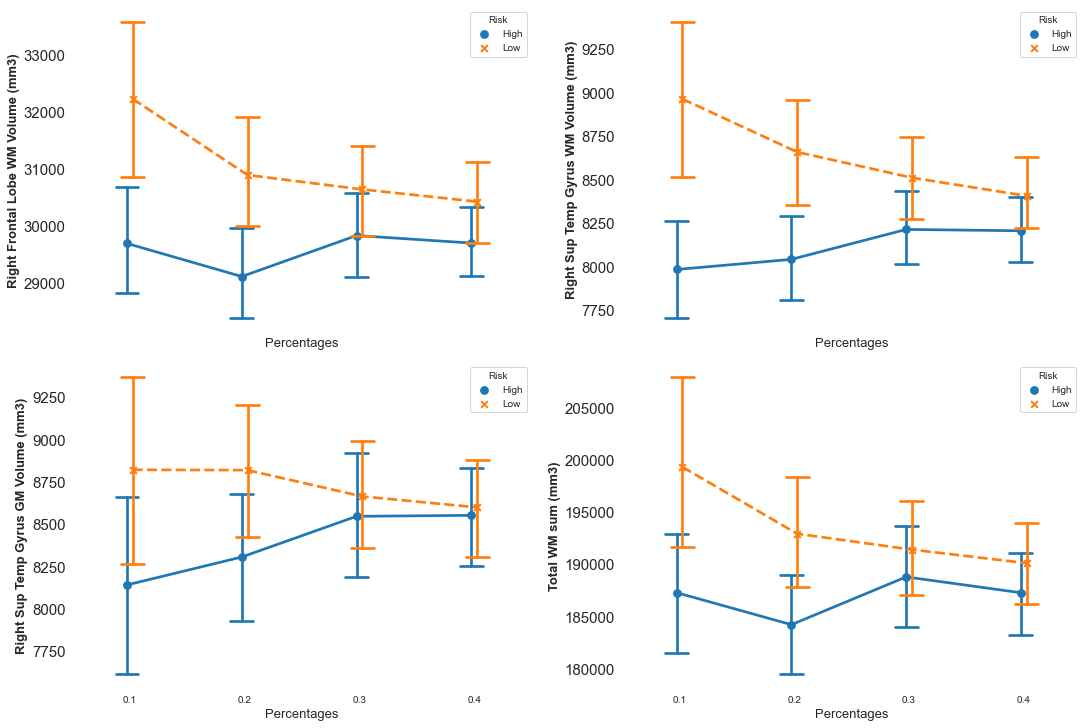

In [144]:
fig,axes = plt.subplots(2,2,figsize=(15,10),constrained_layout=True,sharex=True)
# axes[1,1].remove()
axes = axes.flatten()
for ax, variable,var_name in zip(axes,dependentVar,['Right Frontal Lobe WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus GM Volume (mm3)',
                                                   'Total WM sum (mm3)']):
    sns.pointplot(x='Percentages',
                  y=variable,
                  data=risk_df,
                  hue='Risk',
                  dodge=True,
                 markers=['o','x'],
                 linestyles=['-','--'],capsize=.2,ax=ax)
    sns.despine(top=True,bottom=True,right=True,left=True)
    ax.set_ylabel(var_name,fontdict={'fontsize':13,'fontweight':'bold'})
    ax.set_xlabel('Percentages',fontdict={'fontsize':13})
    ax.tick_params(axis='y', labelsize=15)
# plt.savefig(f'{preprocessed_dataset_path}/output_plot/high_low_risk_european.svg')

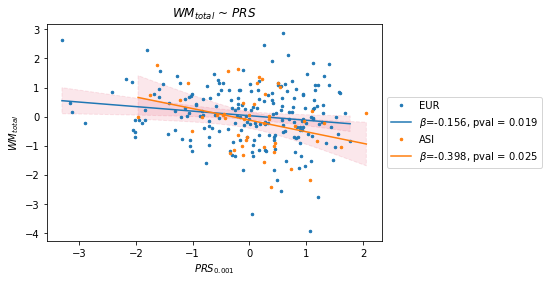

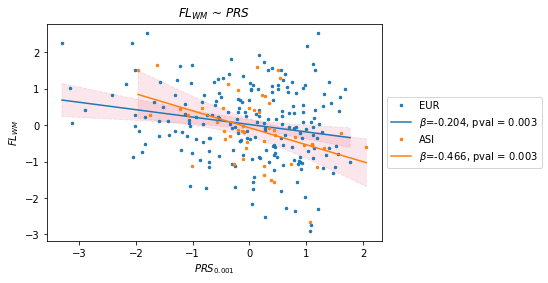

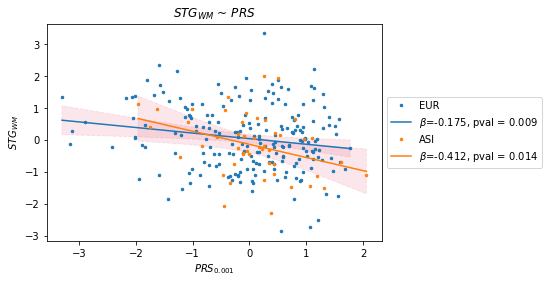

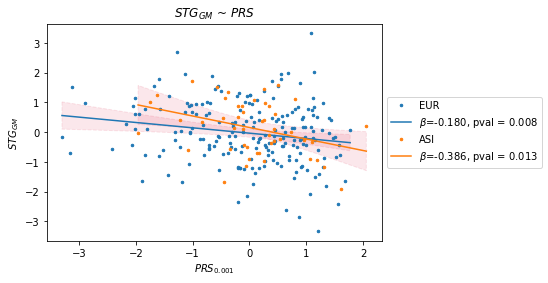

In [11]:
dependent_var = [
    'WM_sum_Imperial', 'Imperial 79', 'Imperial 58', 'Imperial 12'
]
ylbl = ['$WM_{total}$', '$FL_{WM}$', '$STG_{WM}$', '$STG_{GM}$']
ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
df = mixed_volumetric_dataset_term

for var, ylabel in (zip(dependent_var, ylbl)):
    model, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'GA_vol', 'PMA_vol', 'Intracranial_Imperial'
        ],
        dependentVar_cols=[var])
    model2, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=['PRS_0.001'])
#     plt.style.use('seaborn-whitegrid')
    visualisation.plot_Linear_Reg(
        model2.resid.values,
        model.resid.values,
        data=mixed_volumetric_dataset_term,
        ylabel=ylabel,
        xlabel='$PRS_{0.001}$',
        hue='cohort',
        title='%s ~ $PRS$' % ylabel,
        combined=False,
    markersize=5)

## Other tests

### check if removing or adding variables changes the R2

In [13]:
all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(df = mixed_volumetric_dataset_term,
                                           cat_independentVar_cols=['Gender'],
                                           cont_independentVar_cols=['PRS_0.001','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3',
                                                                     'mixed_Anc_PC4','mixed_Anc_PC5',
                                                                    'GA_vol','PMA_vol','Intracranial_Imperial'],
                                          dependentVar_cols=['WM_sum_Imperial'])

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


In [15]:
model_score_summary, model_var_summary, model_beta_summary, model_p_summary = data_exploration.MassUnivariate.preprocess_forward_selection(all_models)

The best model is when including all the covariates, but with less it still achieves similar results

In [22]:
model_score_summary.sort_values(by='R2',ascending=False)

,N_var,AIC,R2,R2_adj
1023,10,215.648386,8.756160e-01,8.705597e-01
1018,9,213.648958,8.756157e-01,8.710835e-01
1020,9,213.742773,8.755703e-01,8.710364e-01
994,8,211.747326,8.755681e-01,8.715541e-01
1019,9,213.916692,8.754860e-01,8.709491e-01
...,...,...,...,...
7,1,731.878817,5.647762e-03,1.748342e-03
47,2,735.165348,6.575971e-04,-7.211241e-03
8,1,733.195754,5.393560e-04,-3.380098e-03
6,1,733.309411,9.725271e-05,-3.823935e-03


<AxesSubplot:xlabel='N_var'>

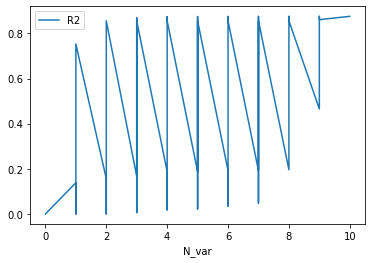

In [24]:
model_score_summary.plot('N_var','R2')

### adding preterm

In [29]:
european_volumetric_preterm_term_mass_univariate = pd.read_csv(
    './preprocessed_dataset/imaging_data/volumetric/preterm_term/european_volumetric_preterm_term_mass_univariate.csv'
)

In [32]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_preterm_term_mass_univariate).sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
630,Imperial 79,0.089234,0.009166,0.222168,1.095722e-10,-0.598642,1.375070e-21,-0.036649,0.158641,-0.028282,0.262465,0.019237,0.433409,1.248126,4.956868e-67,-0.070116,0.005742,-0.197588,0.000222,PRS_0.1
558,Imperial 79,0.088570,0.009781,0.221963,1.188279e-10,-0.599497,1.328617e-21,-0.034744,0.180228,-0.028948,0.252092,0.019136,0.436547,1.249594,4.398070e-67,-0.067245,0.007844,-0.196119,0.000251,PRS_0.05
414,Imperial 79,0.086724,0.011485,0.222626,1.086336e-10,-0.605411,5.751416e-22,-0.031050,0.227522,-0.027863,0.270361,0.014314,0.558126,1.255667,1.133521e-67,-0.064906,0.009110,-0.192031,0.000343,PRS_0.001
270,Imperial 79,0.086523,0.011685,0.222842,1.049350e-10,-0.608548,3.778565e-22,-0.027886,0.275968,-0.026680,0.291166,0.011953,0.624339,1.259979,4.896486e-68,-0.064263,0.009188,-0.191586,0.000354,PRS_1e-05
280,WM_sum_Imperial,0.094424,0.000977,0.186887,7.194661e-11,-0.494796,1.970774e-21,-0.020011,0.346474,-0.022522,0.283408,0.005777,0.775667,1.222138,4.033948e-80,-0.052604,0.010241,-0.209081,0.000003,PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Imperial 55,-0.014055,0.814985,0.294812,7.870784e-07,-0.267992,8.047819e-03,0.062955,0.168771,0.029200,0.512209,0.001909,0.964887,0.784182,5.136692e-16,-0.001004,0.981913,0.031123,0.738435,PRS_0.05
339,Imperial 66,0.102358,0.041317,0.060628,2.105757e-01,-0.551098,2.278240e-10,0.000105,0.997776,-0.027987,0.449537,-0.024654,0.490684,1.202985,3.573970e-40,0.000623,0.986190,-0.226651,0.003773,PRS_0.0001
254,Imperial 51,0.075592,0.178395,0.035679,5.111853e-01,0.075170,4.215992e-01,-0.000051,0.999042,-0.022600,0.586387,-0.015904,0.691993,0.693568,7.734637e-15,0.000643,0.987273,-0.167383,0.055429,PRS_1e-05
38,Imperial 51,0.075549,0.178456,0.035702,5.108313e-01,0.075171,4.215911e-01,-0.000130,0.997530,-0.022595,0.586482,-0.015888,0.692314,0.693525,7.580347e-15,-0.000250,0.995037,-0.167286,0.055354,PRS_1e-08
